# Learning on Graphs

This tutorial is based on the material of Stanford class [CS224W](https://web.stanford.edu/class/cs224w/index.html)

## Graphs with networkx and Pytorch geometric

As usual, some installations and imports. This may take a while:

In [ ]:
import networkx as nx
import torch
import torch.nn as nn
from torch.optim import SGD
import random
import numpy as np
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression


# Install torch geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.4.0+cu121.html
!pip install -q torch-geometric

!pip install git+https://github.com/snap-stanford/ogb.git

from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx

%matplotlib inline
import matplotlib.pyplot as plt

  Cloning https://github.com/snap-stanford/ogb.git to /tmp/pip-req-build-uqst9f0u
  Running command git clone --filter=blob:none --quiet https://github.com/snap-stanford/ogb.git /tmp/pip-req-build-uqst9f0u
  Resolved https://github.com/snap-stanford/ogb.git to commit 861511315ad4b4082d10662d081c3cae14cfc3ea
  Preparing metadata (setup.py) ... done


/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_spmm_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


### Load and examine Zachary's Karate Club Network with networkx

NetworkX is one of the most frequently used Python packages to create, manipulate, and mine graphs.

The Karate Club Network is a graph which describes a social network of 34 members of a karate club and documents links between members who interacted outside the club.

In [ ]:
G = nx.karate_club_graph()

# G is an undirected graph
type(G)

networkx.classes.graph.Graph

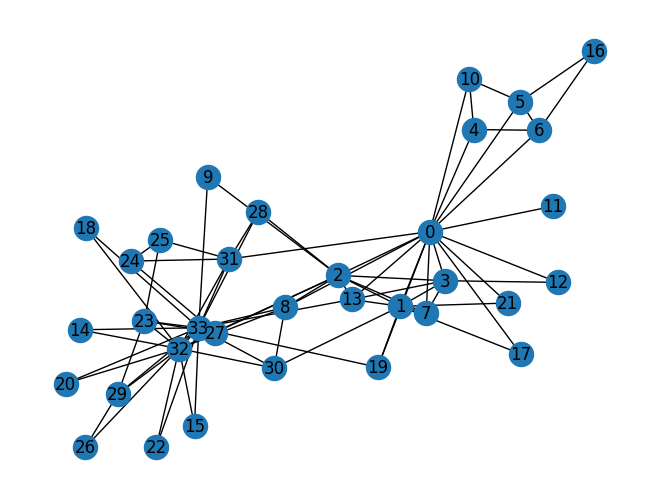

In [ ]:
# Visualize the graph
nx.draw(G, with_labels = True)

In [ ]:
# Let's look at a node
nodes = G.nodes(data=True)
nodes[0]

{'club': 'Mr. Hi'}

In [ ]:
# How many nodes in the graph? How many edges?
N = G.number_of_nodes()
E = G.number_of_edges()
print(N, " nodes, ", E, " edges")

34  nodes,  78  edges


In [ ]:
# Let's look at an edge
edges = G.edges
ij = (0, 11)
if ij in edges:
  print(edges[ij])
else:
  print("Not in the graph")

{'weight': 3}


In [ ]:
# Degree
node_id = 0
G.degree(node_id)

16

In [ ]:
# Neighbors
node_id = 0
list(G.neighbors(node_id))

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 17, 19, 21, 31]

In [ ]:
# Visualization function  for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    else:
        nx.draw_networkx(h, pos=nx.spring_layout(h, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

### Pytorch Geometric

In [ ]:
dataset = KarateClub()
dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


Each graph in PyTorch Geometric is represented by a single [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, which holds all the information to describe its graph representation.

In [ ]:
data = dataset[0]  # Get the first graph object.

print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


The `edge_index` property holds the information about the **graph connectivity**, *i.e.*, a tuple of source and destination node indices for each edge.
PyG further refers to **node features** as `x` (each of the 34 nodes is assigned a 34-dim feature vector), and to **node labels** as `y` (each node is assigned to exactly one class).

In [ ]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


Adjacency list:

In [ ]:
edges = data.edge_index
print(edges.T)

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

This representation is known as the **COO format (coordinate format)** commonly used for representing sparse matrices.
Instead of holding the adjacency information in a dense representation $\mathbf{A} \in \{ 0, 1 \}^{|\mathbb{V}| \times |\mathbb{V}|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $\mathbf{A}$ are non-zero.

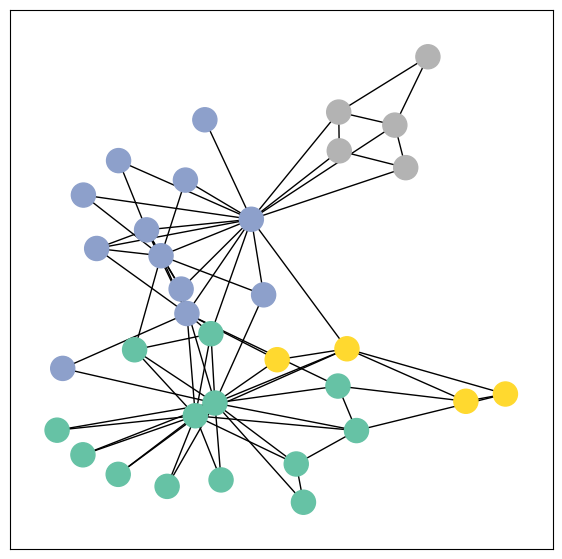

In [ ]:
# From geometric to networkx
data_G = to_networkx(data, to_undirected=True)
visualize(data_G, color=data.y)

# Node Embeddings

In this section we will learn some shallow embeddings for the nodes of the Karate graph

In [ ]:
# Seed for reproducibility
seed = 42

def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

seed_everything(seed)

Let's start with randomly initialized 16-dimensional embeddings (one for each node)

In [ ]:
# 34 16-dimensional embeddings:
emb = nn.Embedding(num_embeddings=34, embedding_dim=16)
print(emb.weight.data.shape)

# Initialize with uniform([0,1))
emb.weight.data = torch.rand(size=emb.weight.data.shape)

torch.Size([34, 16])


In [ ]:
# Select an embedding in emb_sample
id = torch.LongTensor([1])
print(emb(id))

tensor([[0.8414, 0.9740, 0.5268, 0.0699, 0.1492, 0.1894, 0.0594, 0.2494, 0.0397,
         0.0387, 0.2012, 0.0071, 0.1931, 0.6907, 0.9170, 0.3513]],
       grad_fn=<EmbeddingBackward0>)


In [ ]:
# Select multiple embeddings
ids = torch.LongTensor([1, 3])
print(emb(ids))

tensor([[0.8414, 0.9740, 0.5268, 0.0699, 0.1492, 0.1894, 0.0594, 0.2494, 0.0397,
         0.0387, 0.2012, 0.0071, 0.1931, 0.6907, 0.9170, 0.3513],
        [0.1184, 0.5150, 0.2502, 0.1045, 0.4600, 0.0599, 0.8489, 0.5579, 0.2305,
         0.7613, 0.0268, 0.3066, 0.4026, 0.0751, 0.1821, 0.4184]],
       grad_fn=<EmbeddingBackward0>)


We can visualize the embedding in 2D using PCA.

The node attribute "club" tells us which club the member joined after the original club split.

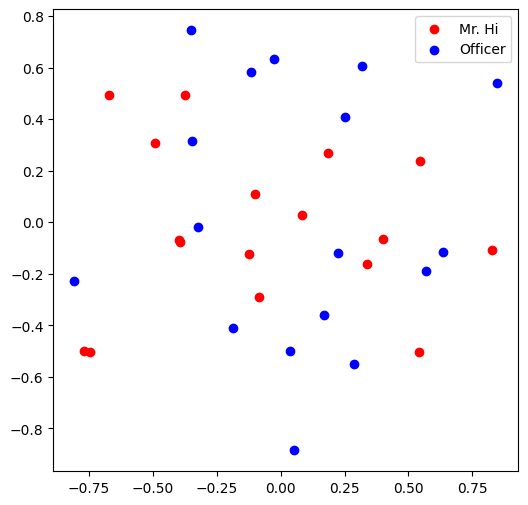

In [ ]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

Let's try to fit a (logistic regression) classifier to predict the club from the node embeddings:

In [ ]:
X = emb.weight.detach().numpy()
y = np.zeros(X.shape[0])
for i in range(G.number_of_nodes()):
  y[i] = G.nodes[i]['club'] == 'Mr. Hi'

clf = LogisticRegression()
clf.fit(X[:27], y[:27])
clf.score(X[27:], y[27:])

0.0

We will take a **random walk** view, which will be useful later...

We train the embedding to maximize the likelihood that **similar** nodes are neighbors in a 1-step random walk on the graph, using dot product as our measure of similarity:

$\mathcal{L} = -\sum_{u\in V}\sum_{v\in\mathrm{neighbors(u)}} \log P(v | u) = -\sum_{u\in V}\sum_{v\in\mathrm{neighbors(u)}} \log \left(\frac{\exp(z_u^Tz_v)}{\sum_{n\in V}\exp(z_u^Tz_n)}\right)$

This is approximated by minimizing **binary cross entropy loss** with positive examples (actual neighbors) and negative examples (randomly sampled "non neighbors" $n_i$)

$\mathcal{L} \simeq -\sum_{u\in V}\sum_{v\in\mathrm{neighbors(u)}} \log(\sigma(z_u^Tz_v)) -\sum_{u\in V}\sum_{i=1}^N \log(1-\sigma(z_u^Tz_{n_i}))$

Generate positive examples (the edges of the graph)

In [ ]:
def positive_samples_adj(G):
  edge_list = []
  for edge in G.edges():
    edge_list.append(edge)

  edge_index = torch.tensor(edge_list).T
  return edge_index

pos_edge_index = positive_samples_adj(G)
pos_edge_index.shape

torch.Size([2, 78])

Generate negative examples (n pairs of nodes that do not share an edge in the graph)

In [ ]:
def negative_samples(G, n):
  neg_edge_list = []

  edge_set = set()
  for edge in G.edges():
    edge_set.add(edge)

  nodes = list(G.nodes)
  for i, node1 in enumerate(nodes):
      for node2 in nodes[i+1:]:
          if (node1, node2) not in edge_set:
            neg_edge_list.append((node1, node2))
  neg_edge_list = random.sample(neg_edge_list, n)
  edge_index = torch.tensor(neg_edge_list).T
  return edge_index

neg_edge_index = negative_samples(G, 78)
neg_edge_index.shape

torch.Size([2, 78])

In [ ]:
def accuracy(pred, label):
  return torch.sum(torch.round(pred) == label) / pred.shape[0]

def train(emb, loss_fn, train_label, train_edge,
          epochs=500,
          learning_rate=0.1):
  optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

  for i in range(epochs):
    sigmoid = nn.Sigmoid()
    optimizer.zero_grad()
    node_emb = emb(train_edge)
    dot_product = torch.sum(node_emb[0] * node_emb[1], -1)
    result = sigmoid(dot_product)
    loss = loss_fn(result, train_label)
    print("Epoch:", i, "Loss:", loss.item(),
          "Acc:", accuracy(result, train_label).item())
    loss.backward()
    optimizer.step()

  return emb

In [ ]:
loss_fn = nn.BCELoss()

pos_edge_index = positive_samples_adj(G)
neg_edge_index = negative_samples(G, n=pos_edge_index.shape[1])

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)
n = len(train_label)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)

# Shuffle
perm = torch.randperm(n)
train_edge = train_edge[:, perm]
train_label = train_label[perm]

train(emb, loss_fn, train_label, train_edge)

Epoch: 0 Loss: 1.8814313411712646 Acc: 0.5
Epoch: 1 Loss: 1.8688215017318726 Acc: 0.5
Epoch: 2 Loss: 1.8450769186019897 Acc: 0.5
Epoch: 3 Loss: 1.811698079109192 Acc: 0.5
Epoch: 4 Loss: 1.770178198814392 Acc: 0.5
Epoch: 5 Loss: 1.721967101097107 Acc: 0.5
Epoch: 6 Loss: 1.66845703125 Acc: 0.5
Epoch: 7 Loss: 1.6109604835510254 Acc: 0.5
Epoch: 8 Loss: 1.550699234008789 Acc: 0.5
Epoch: 9 Loss: 1.4887937307357788 Acc: 0.5
Epoch: 10 Loss: 1.4262540340423584 Acc: 0.5
Epoch: 11 Loss: 1.3639745712280273 Acc: 0.5
Epoch: 12 Loss: 1.3027290105819702 Acc: 0.5
Epoch: 13 Loss: 1.2431681156158447 Acc: 0.5
Epoch: 14 Loss: 1.1858214139938354 Acc: 0.5
Epoch: 15 Loss: 1.1310994625091553 Acc: 0.5
Epoch: 16 Loss: 1.0793005228042603 Acc: 0.5
Epoch: 17 Loss: 1.0306193828582764 Acc: 0.5
Epoch: 18 Loss: 0.9851582050323486 Acc: 0.5
Epoch: 19 Loss: 0.9429394602775574 Acc: 0.5
Epoch: 20 Loss: 0.9039193391799927 Acc: 0.5
Epoch: 21 Loss: 0.8680011034011841 Acc: 0.5
Epoch: 22 Loss: 0.8350480198860168 Acc: 0.512820541

Embedding(34, 16)

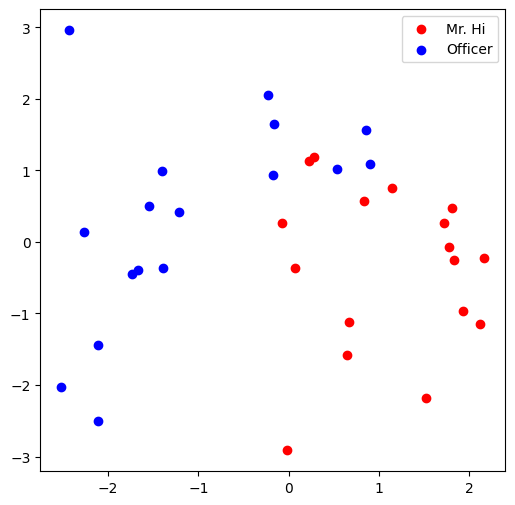

In [ ]:
# Visualize learned embeddings
visualize_emb(emb)

Again, let's try to fit a (logistic regression) classifier to predict the club from the node embeddings:

In [ ]:
X = emb.weight.detach().numpy()
y = np.zeros(X.shape[0])
for i in range(G.number_of_nodes()):
  y[i] = G.nodes[i]['club'] == 'Mr. Hi'

clf = LogisticRegression(random_state=0).fit(X[:27], y[:27])
clf.score(X[27:], y[27:])

0.5714285714285714

**TODO:** RANDOM WALK

Using the negative sampling approach described above, learn a 16-dimensional node embedding based on **first-order unbiased random walks**.

To generate the positive examples, simulate a random walk from each node $u$ in the graph. Start from $u$ and continue the walk by selecting a neighbor of the current node uniformly at random. Every node $v_i$ visited along the walk provides a positive example $(u, v_i)$.

You can generate negative examples at random as before.

In [ ]:
# Implement this function to generate positive examples
# The function takes the graph, the length of walks, and the number of walks to simulate from each node of the graph
def positive_samples_fo(G, length=5, n_walks=10):
  # SOLUTION
  pair_list = []

  nodes = list(G.nodes)
  for source in nodes:
    for _ in range(n_walks):
      # Random walk from source
      n = source
      for i in range(length):
        neighbors = list(G.neighbors(n))
        j = random.randint(0, len(neighbors) - 1)
        n = neighbors[j]
        pair_list.append((source, n))
  return torch.tensor(pair_list).T
  # END SOLUTION

Epoch: 0 Loss: 0.600534200668335 Acc: 0.8500000238418579
Epoch: 1 Loss: 0.5997539162635803 Acc: 0.8500000238418579
Epoch: 2 Loss: 0.598275899887085 Acc: 0.8500000238418579
Epoch: 3 Loss: 0.5961777567863464 Acc: 0.8500000238418579
Epoch: 4 Loss: 0.5935327410697937 Acc: 0.8500000238418579
Epoch: 5 Loss: 0.5904089212417603 Acc: 0.8500000238418579
Epoch: 6 Loss: 0.5868696570396423 Acc: 0.8500000238418579
Epoch: 7 Loss: 0.5829727649688721 Acc: 0.8500000238418579
Epoch: 8 Loss: 0.5787724852561951 Acc: 0.8500000238418579
Epoch: 9 Loss: 0.5743176937103271 Acc: 0.8500000238418579
Epoch: 10 Loss: 0.5696535110473633 Acc: 0.8500000238418579
Epoch: 11 Loss: 0.5648207664489746 Acc: 0.8500000238418579
Epoch: 12 Loss: 0.5598565936088562 Acc: 0.8500000238418579
Epoch: 13 Loss: 0.5547945499420166 Acc: 0.8500000238418579
Epoch: 14 Loss: 0.5496649742126465 Acc: 0.8500000238418579
Epoch: 15 Loss: 0.5444949865341187 Acc: 0.8500000238418579
Epoch: 16 Loss: 0.5393087863922119 Acc: 0.8500000238418579
Epoch: 17

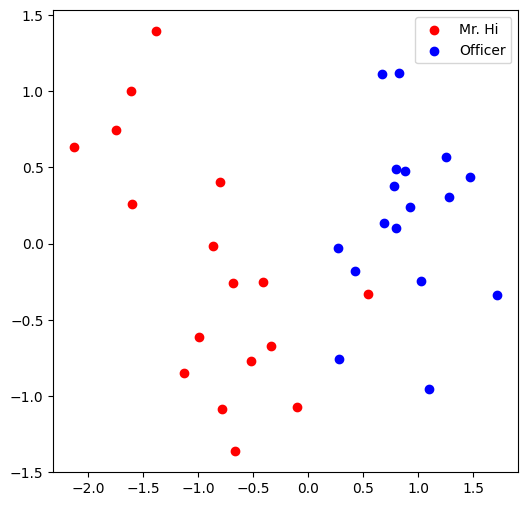

In [ ]:
emb_2 = nn.Embedding(num_embeddings=G.number_of_nodes(), embedding_dim=16)
emb_2.weight.data = torch.rand(size=emb_2.weight.data.shape)

pos_edge_index = positive_samples_fo(G, length=5, n_walks=10)
neg_edge_index = negative_samples(G, n=300)

loss_fn = nn.BCELoss()

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)
n = len(train_label)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)

# Shuffle
perm = torch.randperm(n)
train_edge = train_edge[:, perm]
train_label = train_label[perm]

train(emb_2, loss_fn, train_label, train_edge)

visualize_emb(emb_2)

In [ ]:
X = emb_2.weight.detach().numpy()
y = np.zeros(X.shape[0])
for i in range(G.number_of_nodes()):
  y[i] = G.nodes[i]['club'] == 'Mr. Hi'

clf = LogisticRegression(random_state=0).fit(X[:27], y[:27])
clf.score(X[27:], y[27:])

0.8571428571428571

**TODO**: NODE2VEC

Now you can try to implement **second-order biased random walks** like in node2vec.

For each node $v_i$ in the walk, keep track of its predecessor $v_{i-1}$
The neighbors of $v_i$ are assigned non-uniform probabilities (unnormalized):
* The predecessor $v_{i-1}$ is assigned weight $1/p$ (return parameter)
* Nodes that are *not* neighbors of $v_{i-1}$ are assigned weight $1/q$ (walk-away parameter)
* Other neighbors of $v_i$ are assigned weight $1$

Normalized weights give the distribution of the node to visit after $v_i$

In [ ]:
# Implement this function to generate positive examples
# It takes the graph, the length of the walks, the number of walks
# to simulate from each node of the graph, the return parameter p
# and the walk-away parameter q
def positive_samples_so(G, length=5, n_walks=10, p=1, q=2):
  # SOLUTION
  pair_list = []

  nodes = list(G.nodes)
  for source in nodes:
      for _ in range(n_walks):
        # Random walk from source
        n = source
        for i in range(length):
          if i==0:
            neighbors = list(G.neighbors(n))
            d = len(neighbors)
            j = random.randint(0, len(neighbors) - 1)
            n = neighbors[j]
            pair_list.append((source, n))
          else:
            prev_neighbors = neighbors
            neighbors = list(G.neighbors(n))
            d = len(neighbors)
            probs = np.ones(d)
            for j, m in enumerate(neighbors):
              if m == n:
                probs[j] = 1 / p
              if m not in prev_neighbors:
                probs[j] = 1 / q
            probs = probs / np.sum(probs)
            n = np.random.choice(neighbors, p=probs)
            pair_list.append((source, n))

  return torch.tensor(pair_list).T
  # END SOLUTION

In [ ]:
emb_3 = nn.Embedding(num_embeddings=G.number_of_nodes(), embedding_dim=16)

# Initialize with uniform([0,1))
emb_3.weight.data = torch.rand(size=emb_3.weight.data.shape)

pos_edge_index = positive_samples_so(G, length=5, n_walks=10, p=1, q=2)
neg_edge_index = negative_samples(G, 300)

loss_fn = nn.BCELoss()

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)
n = len(train_label)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)

# Shuffle
perm = torch.randperm(n)
train_edge = train_edge[:, perm]
train_label = train_label[perm]

train(emb_3, loss_fn, train_label, train_edge)

Epoch: 0 Loss: 0.6788421869277954 Acc: 0.8500000238418579
Epoch: 1 Loss: 0.6778278946876526 Acc: 0.8500000238418579
Epoch: 2 Loss: 0.6759058237075806 Acc: 0.8500000238418579
Epoch: 3 Loss: 0.6731767058372498 Acc: 0.8500000238418579
Epoch: 4 Loss: 0.6697343587875366 Acc: 0.8500000238418579
Epoch: 5 Loss: 0.6656661033630371 Acc: 0.8500000238418579
Epoch: 6 Loss: 0.661052942276001 Acc: 0.8500000238418579
Epoch: 7 Loss: 0.6559696197509766 Acc: 0.8500000238418579
Epoch: 8 Loss: 0.6504849791526794 Acc: 0.8500000238418579
Epoch: 9 Loss: 0.6446616649627686 Acc: 0.8500000238418579
Epoch: 10 Loss: 0.638557493686676 Acc: 0.8500000238418579
Epoch: 11 Loss: 0.632224977016449 Acc: 0.8500000238418579
Epoch: 12 Loss: 0.6257118582725525 Acc: 0.8500000238418579
Epoch: 13 Loss: 0.619061291217804 Acc: 0.8500000238418579
Epoch: 14 Loss: 0.6123124361038208 Acc: 0.8500000238418579
Epoch: 15 Loss: 0.6055005788803101 Acc: 0.8500000238418579
Epoch: 16 Loss: 0.5986573696136475 Acc: 0.8500000238418579
Epoch: 17 L

Embedding(34, 16)

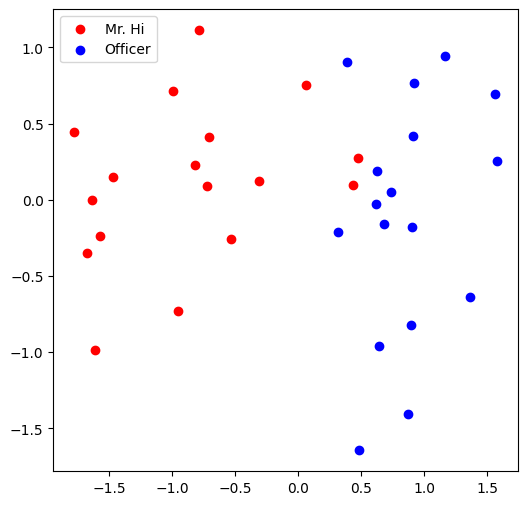

In [ ]:
# Visualize learned embeddings
visualize_emb(emb_3)

In [ ]:
X = emb_3.weight.detach().numpy()
y = np.zeros(X.shape[0])
for i in range(G.number_of_nodes()):
  y[i] = G.nodes[i]['club'] == 'Mr. Hi'

clf = LogisticRegression(random_state=0).fit(X[:27], y[:27])
clf.score(X[27:], y[27:])

0.8571428571428571

## Node Classification with Graph Neural Networks

In this section we will implement a Graph Convolutional Neural Network using PyTorch Geometric.

Some (more) imports first:

In [ ]:
import torch
import torch.nn as nn
import random
import numpy as np

from ogb.nodeproppred import PygNodePropPredDataset

from torch_geometric.datasets import TUDataset
import torch_geometric.transforms as T
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator


%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# Check you are on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)

cpu


In [ ]:
# Seeding
seed = 42

def seed_everything(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

seed_everything(seed)

### The dataset

The Open Graph Benchmark (OGB) is a collection of realistic, large-scale, and diverse benchmark datasets for machine learning on graphs. Its datasets are automatically downloaded, processed, and split using the OGB Data Loader. The model performance can also be evaluated by using the OGB Evaluator in a unified manner.

 The ogbn-arxiv dataset is a directed graph, representing the citation network between all Computer Science (CS) arXiv papers indexed by MAG. Each node is an arXiv paper and each directed edge indicates that one paper cites another one. Each paper comes with a 128-dimensional feature vector obtained by averaging the embeddings of words in its title and abstract.

The **node classification** task is to predict the 40 subject areas of arXiv CS papers, e.g., cs.AI, cs.LG, and cs.OS, which are manually determined (i.e., labeled) by the paper's authors and arXiv moderators.

In [ ]:
dataset_name = 'ogbn-arxiv'
dataset = PygNodePropPredDataset(name=dataset_name,
                                 root='./arxiv',
                                 transform=T.ToSparseTensor())


In [ ]:
# Just one graph
print(len(dataset))

G = dataset[0]

print(G)

print(G.num_features)

print(dataset.num_classes)

1
Data(num_nodes=169343, x=[169343, 128], node_year=[169343, 1], y=[169343, 1], adj_t=[169343, 169343])
128
40


/usr/local/lib/python3.11/dist-packages/torch_geometric/utils/sparse.py:277: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj = torch.sparse_csr_tensor(


It's important to understand our data. The input to the network will be the node features..

In [ ]:
G.x.shape

torch.Size([169343, 128])

...but also the graph connectivity:

In [ ]:
G.adj_t.shape

torch.Size([169343, 169343])

In [ ]:
G.adj_t

tensor(crow_indices=tensor([      0,     289,     290,  ..., 1166240,
                            1166243, 1166243]),
       col_indices=tensor([   411,    640,   1162,  ...,  30351,  35711,
                           103121]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]), size=(169343, 169343),
       nnz=1166243, layout=torch.sparse_csr)

### The model

![test](https://drive.google.com/uc?id=128AuYAXNXGg7PIhJJ7e420DoPWKb-RtL)

**TODO:** implement the Graph Convolutional Neural Network outlined above, using torch geometric's implementation of the graph convolution operator as the main building block: [GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html)

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers,
                 dropout):

        super(GCN, self).__init__()

        self.dropout = dropout

        # A list of GCNConv layers
        self.convs = torch.nn.ModuleList(
            [GCNConv(in_channels=input_dim, out_channels=hidden_dim)] +
            [GCNConv(in_channels=hidden_dim, out_channels=hidden_dim)
                for i in range(num_layers-2)] +
            [GCNConv(in_channels=hidden_dim, out_channels=output_dim)]
        )

        # A list of 1D batch normalization layers
        self.bns = torch.nn.ModuleList([
            torch.nn.BatchNorm1d(num_features=hidden_dim)
                for i in range(num_layers-1)
        ])


        # The log softmax layer
        self.softmax = torch.nn.LogSoftmax()

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for bn in self.bns:
            bn.reset_parameters()

    def forward(self, x, adj_t):
        for conv, bn in zip(self.convs[:-1], self.bns):
            x1 = F.relu(bn(conv(x, adj_t)))
            if self.training:
                x1 = F.dropout(x1, p=self.dropout)
            x = x1
        x = self.convs[-1](x, adj_t)
        out = self.softmax(x)
        return out

The following function implements a training epoch:

In [ ]:
def train(model, data, train_idx, optimizer, loss_fn):
    model.train()
    loss = 0

    optimizer.zero_grad()
    out = model(data.x, data.adj_t)
    loss = loss_fn(out[train_idx], data.y[train_idx].reshape(-1))

    loss.backward()
    optimizer.step()

    return loss.item()

Here is a function to evaluate the model:

In [ ]:
@torch.no_grad()
def test(model, data, split_idx, evaluator):
    model.eval()

    out = model(data.x, data.adj_t)

    y_pred = out.argmax(dim=-1, keepdim=True)

    train_acc = evaluator.eval({
        'y_true': data.y[split_idx['train']],
        'y_pred': y_pred[split_idx['train']],
    })['acc']
    valid_acc = evaluator.eval({
        'y_true': data.y[split_idx['valid']],
        'y_pred': y_pred[split_idx['valid']],
    })['acc']
    test_acc = evaluator.eval({
        'y_true': data.y[split_idx['test']],
        'y_pred': y_pred[split_idx['test']],
    })['acc']

    return train_acc, valid_acc, test_acc

Here are some suggested hyperparmeters:

In [ ]:
args = {
    'num_layers': 3,
    'hidden_dim': 256,
    'dropout': 0.2,
    'lr': 0.05,
    'epochs': 100,
}

We split data for training/validation/testing and prepare our model:

In [ ]:
G = G.to(device)
split_idx = dataset.get_idx_split()
train_idx = split_idx['train'].to(device)

model = GCN(G.num_features, args['hidden_dim'],
            dataset.num_classes, args['num_layers'],
            args['dropout']).to(device)
evaluator = Evaluator(name='ogbn-arxiv')

Time for training:

In [ ]:
import copy

# reset the parameters to initial random value
model.reset_parameters()

optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'])
loss_fn = F.nll_loss # negative log likelihood

best_model = None
best_valid_acc = 0

for epoch in range(1, 1 + args["epochs"]):
  loss = train(model, G, train_idx, optimizer, loss_fn)
  result = test(model, G, split_idx, evaluator)
  train_acc, valid_acc, test_acc = result
  if valid_acc > best_valid_acc:
      best_valid_acc = valid_acc
      best_model = copy.deepcopy(model)
  print(f'Epoch: {epoch:02d}, '
        f'Loss: {loss:.4f}, '
        f'Train: {100 * train_acc:.2f}%, '
        f'Valid: {100 * valid_acc:.2f}% ')

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 01, Loss: 4.5133, Train: 23.82%, Valid: 17.69% 
Epoch: 02, Loss: 3.4964, Train: 11.94%, Valid: 17.41% 
Epoch: 03, Loss: 4.1450, Train: 5.78%, Valid: 10.48% 
Epoch: 04, Loss: 3.1191, Train: 17.75%, Valid: 30.01% 
Epoch: 05, Loss: 2.8876, Train: 20.10%, Valid: 26.52% 
Epoch: 06, Loss: 2.7856, Train: 27.63%, Valid: 29.88% 
Epoch: 07, Loss: 2.6807, Train: 28.28%, Valid: 29.15% 
Epoch: 08, Loss: 2.5836, Train: 27.38%, Valid: 28.03% 
Epoch: 09, Loss: 2.4917, Train: 28.58%, Valid: 31.20% 
Epoch: 10, Loss: 2.4041, Train: 32.25%, Valid: 36.55% 
Epoch: 11, Loss: 2.3345, Train: 35.97%, Valid: 40.47% 
Epoch: 12, Loss: 2.2826, Train: 38.30%, Valid: 42.81% 
Epoch: 13, Loss: 2.2423, Train: 39.94%, Valid: 44.34% 
Epoch: 14, Loss: 2.2022, Train: 41.25%, Valid: 45.40% 
Epoch: 15, Loss: 2.1550, Train: 42.39%, Valid: 46.35% 
Epoch: 16, Loss: 2.1121, Train: 43.65%, Valid: 47.30% 
Epoch: 17, Loss: 2.0745, Train: 45.03%, Valid: 48.42% 
Epoch: 18, Loss: 2.0442, Train: 46.30%, Valid: 49.30% 
Epoch: 19, 

Let's see how we did on the test data

In [ ]:
best_result = test(best_model, G, split_idx, evaluator)
train_acc, valid_acc, test_acc = best_result
print(f'Best model: '
      f'Test: {100 * test_acc:.2f}%')

Best model: Test: 51.13%
